In [76]:
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

#!pip install "numpy>=1.22.3,<1.23.0"

In [77]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from IPython.display import clear_output

from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from sklearn import svm
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_class_weight

## Loading the dataset

In [78]:
# @title
HOME_DIR = "https://raw.githubusercontent.com/msusol/kaggle/main/notebooks/playground-series-s4e1/" # @param ["/kaggle/input/playground-series-s4e1/", "https://raw.githubusercontent.com/msusol/kaggle/main/notebooks/playground-series-s4e1/"]

In [79]:
train = pd.read_csv(f'{HOME_DIR}/train.csv')
train['split'] = 'train'
test = pd.read_csv(f'{HOME_DIR}/test.csv')
test['split'] = 'test'

df = pd.concat([train, test], ignore_index=True)
df.sample(10)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,split
118555,118555,15649150,Hsieh,651,Spain,Female,43.0,9,0.00,1,1.0,1.0,113089.43,1.0,train
51084,51084,15621031,White,624,France,Female,33.0,8,0.00,2,1.0,1.0,62674.38,0.0,train
127857,127857,15724339,Chiang,676,Germany,Female,40.0,6,153871.52,1,1.0,1.0,170819.03,1.0,train
258164,258164,15580038,Scott,669,France,Male,35.0,1,0.00,2,1.0,0.0,56794.41,NaN,test
136935,136935,15737267,Nwachukwu,679,France,Female,46.0,6,178095.55,1,1.0,0.0,103921.43,1.0,train
222479,222479,15774277,Tung,554,Germany,Female,38.0,5,145512.84,2,1.0,0.0,104120.17,NaN,test
222592,222592,15609558,Udinese,554,Spain,Female,37.0,6,0.00,2,1.0,1.0,96656.33,NaN,test
132686,132686,15711130,Tseng,734,France,Male,45.0,2,0.00,1,1.0,0.0,99593.28,0.0,train
11292,11292,15591428,Miles,674,Germany,Male,43.0,8,85957.88,1,1.0,0.0,8757.39,0.0,train
165812,165812,15591036,Shih,679,Spain,Female,51.0,1,0.00,1,1.0,0.0,88965.46,NaN,test


## Understanding the dataset


In [80]:
#!pip3 install -U ydata_profiling
#clear_output()

# https://github.com/ydataai/ydata-profiling
from ydata_profiling import ProfileReport

#profile = ProfileReport(df.loc[:, df.columns != 'split'], explorative=True)
#profile.to_notebook_iframe()

#profile.to_file("output.html")

## Feature Engineering

Drop the features we expect to ignore in our feature set.

Encode the `bool` type columns to simple `0|1` values.

In [81]:
df.drop(columns=['CustomerId'], inplace=True)

bool_categories = ['HasCrCard', 'IsActiveMember', 'Exited']
df[bool_categories] = df[bool_categories].apply(lambda x: x.astype('bool').astype(int)) # bool -> int preserves nulls as False.

#df['Gender'] = df['Gender'].replace(['Female'], '0')
#df['Gender'] = df['Gender'].replace(['Male'], '1')
#df['Gender'] = pd.to_numeric(df['Gender'])

df['Age'] = df['Age'].astype(int)

df.head()

,id,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,split
0,0,Okwudilichukwu,668,France,Male,33,3,0.00,2,1,0,181449.97,0,train
1,1,Okwudiliolisa,627,France,Male,33,1,0.00,2,1,1,49503.50,0,train
2,2,Hsueh,678,France,Male,40,10,0.00,2,1,0,184866.69,0,train
3,3,Kao,581,France,Male,34,2,148882.54,1,1,1,84560.88,0,train
4,4,Chiemenam,716,Spain,Male,33,5,0.00,2,1,1,15068.83,0,train


In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275057 entries, 0 to 275056
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               275057 non-null  int64  
 1   Surname          275057 non-null  object 
 2   CreditScore      275057 non-null  int64  
 3   Geography        275057 non-null  object 
 4   Gender           275057 non-null  object 
 5   Age              275057 non-null  int64  
 6   Tenure           275057 non-null  int64  
 7   Balance          275057 non-null  float64
 8   NumOfProducts    275057 non-null  int64  
 9   HasCrCard        275057 non-null  int64  
 10  IsActiveMember   275057 non-null  int64  
 11  EstimatedSalary  275057 non-null  float64
 12  Exited           275057 non-null  int64  
 13  split            275057 non-null  object 
dtypes: float64(2), int64(8), object(4)
memory usage: 29.4+ MB


### Categorical Features

First, set the categorical features by `type`. We expect `object` to change `category`.

In [83]:
categorical_columns = list(df.select_dtypes(include=['object']).columns)
df[categorical_columns] = df[categorical_columns].apply(lambda x: x.astype('category'))

print(categorical_columns)
df.info()

['Surname', 'Geography', 'Gender', 'split']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275057 entries, 0 to 275056
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   id               275057 non-null  int64   
 1   Surname          275057 non-null  category
 2   CreditScore      275057 non-null  int64   
 3   Geography        275057 non-null  category
 4   Gender           275057 non-null  category
 5   Age              275057 non-null  int64   
 6   Tenure           275057 non-null  int64   
 7   Balance          275057 non-null  float64 
 8   NumOfProducts    275057 non-null  int64   
 9   HasCrCard        275057 non-null  int64   
 10  IsActiveMember   275057 non-null  int64   
 11  EstimatedSalary  275057 non-null  float64 
 12  Exited           275057 non-null  int64   
 13  split            275057 non-null  category
dtypes: category(4), float64(2), int64(8)
memory usage: 22.4 MB


**Strategies to encode categories**

- Encoding ordinal categories
The most intuitive strategy is to encode each category with a different number. The `OrdinalEncoder` transforms the data in such manner. We start by encoding a single column to understand how the encoding works.

- Encoding nominal categories (without assuming any order)
`OneHotEncoder` is an alternative encoder that prevents the downstream models to make a false assumption about the ordering of categories.

In [84]:
credit_scores = {
    'Poor: 300 to 579': 300,
    'Fair: 580 to 669': 580,
    'Good: 670 to 739': 670,
    'Very good: 740 to 799': 740,
    'Exceptional: 800 to 850': 800
}

scores = list(credit_scores.values()) + [850]
labels = list(credit_scores.keys())

df['CreditScoreBin'] = pd.cut(df.CreditScore, bins=scores, labels=labels)

# https://www.beresfordresearch.com/age-range-by-generation/
generations = {
    'Gen Z: 12 – 27': 12,
    'Millennials: 28 – 43': 28,
    'Gen X: 44 – 59': 44,
    'Boomers II: 60 – 69': 60, # aka Generation Jones
    'Boomers I: 70 – 78': 70,
    'Post War: 79 – 96': 79,
    'WWII: 97 – 102': 97
}
generations

scores = list(generations.values()) + [102]
labels = list(generations.keys())

df['AgeBin'] = pd.cut(df.Age, bins=scores, labels=labels)

tenure = {
    'Low': 0,    # 0-2
    'Medium': 2, # 2–5
    'High': 5    # 5–10
}

scores = list(tenure.values()) + [10]
labels = list(tenure.keys())

df['TenureBin'] = pd.cut(df.Tenure, bins=scores, labels=labels, include_lowest=True) # Handle zeros as LOW = 0 (['Medium', 'Low', 'High', NaN])

df.drop(columns=['CreditScore', 'Age', 'Tenure'], inplace=True)

df.head()

,id,Surname,Geography,Gender,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,split,CreditScoreBin,AgeBin,TenureBin
0,0,Okwudilichukwu,France,Male,0.00,2,1,0,181449.97,0,train,Fair: 580 to 669,Millennials: 28 – 43,Medium
1,1,Okwudiliolisa,France,Male,0.00,2,1,1,49503.50,0,train,Fair: 580 to 669,Millennials: 28 – 43,Low
2,2,Hsueh,France,Male,0.00,2,1,0,184866.69,0,train,Good: 670 to 739,Millennials: 28 – 43,High
3,3,Kao,France,Male,148882.54,1,1,1,84560.88,0,train,Fair: 580 to 669,Millennials: 28 – 43,Low
4,4,Chiemenam,Spain,Male,0.00,2,1,1,15068.83,0,train,Good: 670 to 739,Millennials: 28 – 43,Medium


In [85]:
# See Model Selection
df_catboost = df.copy()

Continue with making binned categories

In [86]:
df.drop(columns=['Surname'], inplace=True)

df['Gender'] = df['Gender'].replace(['Female'], '0')
df['Gender'] = df['Gender'].replace(['Male'], '1')
df['Gender'] = pd.to_numeric(df['Gender'])

In [87]:
ord_features = ['CreditScoreBin', 'AgeBin', 'TenureBin']
ordinal_transformer = OrdinalEncoder(
    categories=[
        sorted(credit_scores, key=credit_scores.get),
        sorted(generations, key=generations.get),
        sorted(tenure, key=tenure.get),
    ])

cat_features = ['Geography'] # NO Surname
categorical_transformer = OneHotEncoder(sparse_output=False)

ct = ColumnTransformer(
    transformers=[
        ('ord', ordinal_transformer, ord_features),
        ('cat', categorical_transformer, cat_features)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False # removes `remainder__` prefixes
)

ct.set_output(transform='pandas')

df_tranformed = ct.fit_transform(df)
df_tranformed.head()

,CreditScoreBin,AgeBin,TenureBin,Geography_France,Geography_Germany,Geography_Spain,id,Gender,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,split
0,1.0,1.0,1.0,1.0,0.0,0.0,0,1,0.00,2,1,0,181449.97,0,train
1,1.0,1.0,0.0,1.0,0.0,0.0,1,1,0.00,2,1,1,49503.50,0,train
2,2.0,1.0,2.0,1.0,0.0,0.0,2,1,0.00,2,1,0,184866.69,0,train
3,1.0,1.0,0.0,1.0,0.0,0.0,3,1,148882.54,1,1,1,84560.88,0,train
4,2.0,1.0,1.0,0.0,0.0,1.0,4,1,0.00,2,1,1,15068.83,0,train


In [88]:
ordinal_transformer.categories

[['Poor: 300 to 579',
  'Fair: 580 to 669',
  'Good: 670 to 739',
  'Very good: 740 to 799',
  'Exceptional: 800 to 850'],
 ['Gen Z: 12 – 27',
  'Millennials: 28 – 43',
  'Gen X: 44 – 59',
  'Boomers II: 60 – 69',
  'Boomers I: 70 – 78',
  'Post War: 79 – 96',
  'WWII: 97 – 102'],
 ['Low', 'Medium', 'High']]

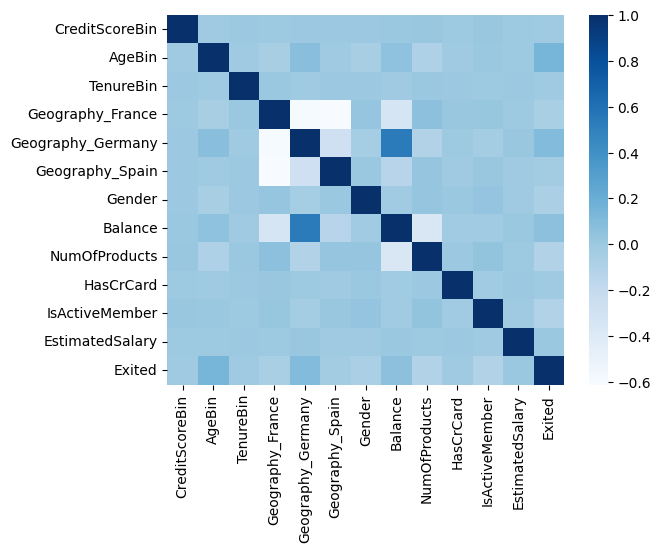

In [89]:
sns.heatmap(df_tranformed.drop(['id', 'split'], axis=1).corr(), cmap='Blues')
plt.show()

### Train/Test Split

In [90]:
train = df_tranformed[df_tranformed['split'] == 'train']

X = train.drop(['Exited', 'id', 'split'], axis=1)  # drop `id` during training
y = train['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

X_train.sample(10)

,CreditScoreBin,AgeBin,TenureBin,Geography_France,Geography_Germany,Geography_Spain,Gender,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
86736,2.0,1.0,2.0,1.0,0.0,0.0,0,0.00,1,1,0,160523.33
124762,1.0,1.0,1.0,0.0,0.0,1.0,0,81568.94,1,0,0,104379.36
131159,0.0,1.0,1.0,1.0,0.0,0.0,0,0.00,1,0,1,65166.60
61035,0.0,2.0,2.0,0.0,1.0,0.0,1,118050.79,1,1,1,89801.90
36676,3.0,0.0,0.0,1.0,0.0,0.0,1,0.00,2,0,1,199357.31
17273,2.0,2.0,2.0,0.0,0.0,1.0,0,105583.38,1,1,1,127557.83
99932,3.0,1.0,1.0,0.0,0.0,1.0,0,0.00,1,1,0,163524.70
23427,1.0,2.0,0.0,1.0,0.0,0.0,0,0.00,1,0,0,164482.92
158968,1.0,1.0,2.0,1.0,0.0,0.0,1,0.00,2,1,1,35342.83
60336,4.0,1.0,0.0,0.0,0.0,1.0,1,133463.10,1,1,1,188343.05


### Imbalanced Data

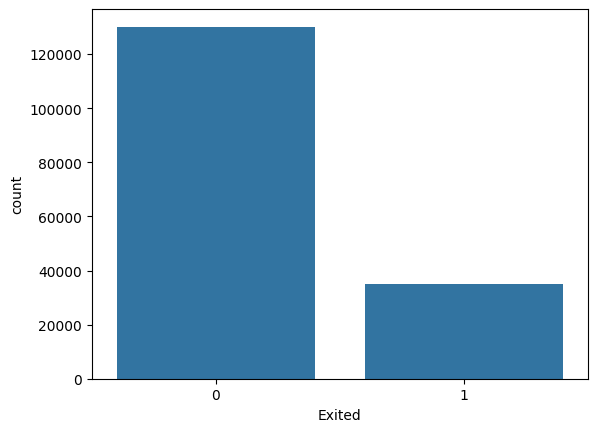

In [91]:
sns.countplot(data=train, x=train.Exited)
plt.show()

#class imbalance? predict the minority class is best
#df = df_tranformed

#np.unique(df['Exited'][df['split'] == 'train'], return_counts=True)

https://medium.com/@data.science.enthusiast/how-to-improve-logistic-regression-in-imbalanced-data-with-class-weights-1693719136aa

In [92]:
classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weights = dict(zip(classes, weights))

sample_weights = np.zeros(len(y_train))
sample_weights[y_train == 0] = class_weights[0]
sample_weights[y_train == 1] = class_weights[1]

print(class_weights)
print(sample_weights)

{0: 0.6341948921322236, 1: 2.362962114486985}
[2.36296211 0.63419489 0.63419489 ... 0.63419489 0.63419489 0.63419489]


## Model Evaluation

In [93]:
def plot_roc_curve(model):
    """
    Usage:
      model=DecisionTreeClassifier(class_weight=class_weights, max_depth=8, random_state=42)
      model.fit(X_train, y_train)
      plot_roc_curve(model)
    """
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[::,1]
    accuracy = accuracy_score(y_test, y_pred).round(4)
    auc = roc_auc_score(y_test, y_pred_proba).round(4)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

    plt.plot([0, 1], [0, 1], linestyle='--', color='k')
    plt.plot(fpr, tpr, label='AUC=%0.4f'%(auc))
    plt.title('ROC Curve : %s'%(type(model)))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=0)
    plt.show()

def plot_roc_curves(results, type='Evaluation'):
    fig, axes = plt.subplots(1, 1, figsize=(8, 8))

    plt.title('ROC Curve : %s'%type)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

    legend = []
    for reg in results[type]:
        plt.plot(results[type][reg]['fpr'], results[type][reg]['tpr'])
        legend.append('%s, AUC=%0.4f'%(reg, results[type][reg]['auc']))

    plt.legend(legend)
    plt.plot([0, 1], [0, 1], linestyle='--', color='k')
    plt.show()

def print_results():
  return pd.DataFrame.from_dict({
    (i, j): results[i][j]
    for i in results.keys() for j in results[i].keys()}, orient='index')

def run_classifier(model, type='Evaluation', random_state=42, class_weights=None, sample_weights=None, max_depth=None):
    model_name = model.__name__
    print('...running ', model_name)

    if class_weights and max_depth:
        classifier = model(random_state=random_state, class_weight=class_weights, max_depth=max_depth)
    elif class_weights:
        classifier = model(random_state=random_state, class_weight=class_weights)
    elif max_depth:
        classifier = model(random_state=random_state, max_depth=max_depth)
    else:
        classifier = model(random_state=random_state)

    if not sample_weights is None:
        classifier.fit(X_train, y_train, sample_weight=sample_weights)
    else:
        classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)
    y_pred_proba = classifier.predict_proba(X_test)[::,1]
    if not type in results: results[type] = {}
    if not model_name in results: results[type][model_name] = {}
    results[type][model_name]['accuracy'] = accuracy_score(y_test, y_pred).round(4)
    results[type][model_name]['auc'] = roc_auc_score(y_test, y_pred_proba).round(4)
    results[type][model_name]['fpr'], results[type][model_name]['tpr'], _ = roc_curve(y_test, y_pred_proba)

results = {}

run_classifier(LogisticRegression, class_weights=class_weights)
run_classifier(DecisionTreeClassifier, class_weights=class_weights, max_depth=8)
run_classifier(RandomForestClassifier, class_weights=class_weights, max_depth=8)
#run_classifier(svm.SVC) # AttributeError: predict_proba is not available when probability=False
run_classifier(XGBClassifier, sample_weights=sample_weights)
run_classifier(CatBoostClassifier) # all numerical features here
run_classifier(GradientBoostingClassifier, sample_weights=sample_weights)

clear_output()

print_results()

accuracy     auc  \
Evaluation LogisticRegression            0.5837  0.5755   
           DecisionTreeClassifier        0.7959  0.8744   
           RandomForestClassifier        0.7923  0.8777   
           XGBClassifier                 0.8026  0.8755   
           CatBoostClassifier            0.8577  0.8784   
           GradientBoostingClassifier    0.7970  0.8802   

                                                                                     fpr  \
Evaluation LogisticRegression          [0.0, 0.0, 7.736644617229508e-05, 7.7366446172...   
           DecisionTreeClassifier      [0.0, 0.00015473289234459016, 0.00027078256160...   
           RandomForestClassifier      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.8683223086147...   
           XGBClassifier               [0.0, 0.0, 0.0, 3.868322308614754e-05, 3.86832...   
           CatBoostClassifier          [0.0, 0.0, 0.0, 3.868322308614754e-05, 3.86832...   
           GradientBoostingClassifier  [0.0, 0.0, 0.0, 0.0, 0.0, 3.868322308614754e-0...   

                                                                                     tpr  
Evaluation LogisticRegression          [0.0, 0.00013974287311347122, 0.00013974287311...  
           DecisionTreeClassifier      [0.0, 0.005869200670765791, 0.0113191727221911...  
           RandomForestClassifier      [0.0, 0.00013974287311347122, 0.00041922861934...  
           XGBClassifier               [0.0, 0.00013974287311347122, 0.00279485746226...  
           CatBoostClassifier          [0.0, 0.00013974287311347122, 0.00237562884292...  
           GradientBoostingClassifier  [0.0, 0.00013974287311347122, 0.00181665735047...

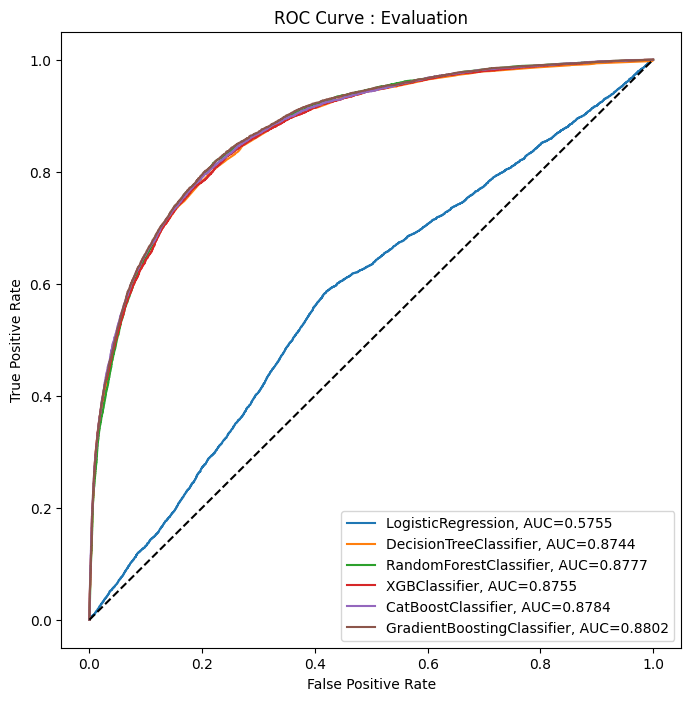

In [94]:
plot_roc_curves(results)

## Model Selected

### GradientBoostingClassifier

In [95]:
df = df_tranformed.copy()

train = df[df['split'] == 'train']

X = train.drop(['Exited', 'id', 'split'], axis=1)  # drop `id` during training
y = train['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

X_train.sample(10)

,CreditScoreBin,AgeBin,TenureBin,Geography_France,Geography_Germany,Geography_Spain,Gender,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
163744,1.0,1.0,2.0,0.0,1.0,0.0,1,82405.95,2,1,0,162428.05
148086,1.0,1.0,2.0,0.0,0.0,1.0,0,123925.23,1,1,0,73641.86
5445,1.0,1.0,2.0,1.0,0.0,0.0,1,88293.84,1,1,0,126772.42
86934,0.0,1.0,0.0,0.0,1.0,0.0,1,132835.56,2,1,0,124525.24
42451,1.0,1.0,2.0,0.0,1.0,0.0,1,128981.59,1,1,0,51871.24
99428,0.0,1.0,2.0,1.0,0.0,0.0,1,0.00,2,1,1,80190.61
42233,1.0,1.0,1.0,1.0,0.0,0.0,1,141616.55,1,0,1,138889.15
142847,2.0,1.0,1.0,1.0,0.0,0.0,0,0.00,2,0,1,138877.25
25464,0.0,1.0,0.0,1.0,0.0,0.0,0,0.00,2,1,0,139463.57
155001,2.0,1.0,1.0,1.0,0.0,0.0,1,178095.55,1,0,1,90928.48


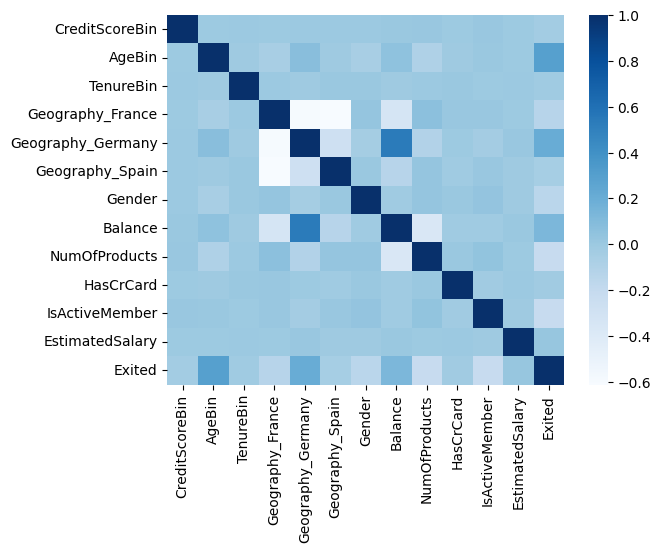

In [96]:
sns.heatmap(df[df['split'] == 'train'].drop(['id', 'split'], axis=1).corr(), cmap='Blues')
plt.show()

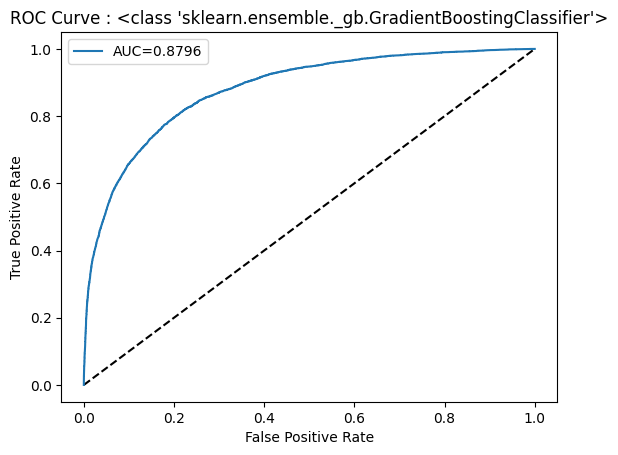

In [97]:
params = {
    'n_estimators': 1000,
    'max_depth': 3,
    'subsample': 0.8,
    'max_features' : 'sqrt',
    'learning_rate': 0.015,
    'min_samples_split': 2,
    'random_state': 42
}

model = GradientBoostingClassifier(**params)
model.fit(X_train, y_train, sample_weight=sample_weights)
clear_output()

def plot_roc_curve(model):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[::,1]
    accuracy = accuracy_score(y_test, y_pred).round(4)
    auc = roc_auc_score(y_test, y_pred_proba).round(4)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

    plt.plot([0, 1], [0, 1], linestyle='--', color='k')
    plt.plot(fpr, tpr, label='AUC=%0.4f'%(auc))
    plt.title('ROC Curve : %s'%(type(model)))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=0)
    plt.show()

plot_roc_curve(model)

### CatBoostClassifier

In [98]:
df_catboost.head() # Must have `Surname`

,id,Surname,Geography,Gender,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,split,CreditScoreBin,AgeBin,TenureBin
0,0,Okwudilichukwu,France,Male,0.00,2,1,0,181449.97,0,train,Fair: 580 to 669,Millennials: 28 – 43,Medium
1,1,Okwudiliolisa,France,Male,0.00,2,1,1,49503.50,0,train,Fair: 580 to 669,Millennials: 28 – 43,Low
2,2,Hsueh,France,Male,0.00,2,1,0,184866.69,0,train,Good: 670 to 739,Millennials: 28 – 43,High
3,3,Kao,France,Male,148882.54,1,1,1,84560.88,0,train,Fair: 580 to 669,Millennials: 28 – 43,Low
4,4,Chiemenam,Spain,Male,0.00,2,1,1,15068.83,0,train,Good: 670 to 739,Millennials: 28 – 43,Medium


In [100]:
# Our chosen classifier regressor.

# CatBoostClassifier
df = df_catboost.copy()

train = df[df['split'] == 'train']

X = train.drop(['Exited', 'id', 'split'], axis=1)  # drop `id` during training
y = train['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

categorical_features = list(X.select_dtypes(include='category').columns)

print(categorical_features)
X_train.sample(10)

['Surname', 'Geography', 'Gender', 'CreditScoreBin', 'AgeBin', 'TenureBin']


,Surname,Geography,Gender,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,CreditScoreBin,AgeBin,TenureBin
61508,Onwughara,Germany,Male,123894.43,2,1,0,79928.41,Good: 670 to 739,Millennials: 28 – 43,High
14650,Obidimkpa,Germany,Male,149117.71,2,0,0,100995.99,Good: 670 to 739,Millennials: 28 – 43,High
149346,Nwachukwu,Spain,Male,0.00,2,1,1,26170.06,Poor: 300 to 579,Boomers I: 70 – 78,Medium
140308,Pinto,Spain,Male,0.00,2,0,0,80963.92,Poor: 300 to 579,Millennials: 28 – 43,High
56255,Ndubueze,France,Female,138082.16,1,0,0,115068.99,Good: 670 to 739,Millennials: 28 – 43,Low
135213,Mazzanti,France,Male,137273.95,2,0,0,177546.01,Very good: 740 to 799,Millennials: 28 – 43,High
26591,Kao,France,Female,0.00,2,1,1,35450.97,Fair: 580 to 669,Millennials: 28 – 43,High
4986,Maclean,Spain,Female,0.00,2,1,0,131408.01,Exceptional: 800 to 850,Millennials: 28 – 43,High
131263,Belov,France,Male,0.00,2,1,1,36154.66,Fair: 580 to 669,Gen X: 44 – 59,Low
14950,Hamilton,France,Female,0.00,1,1,0,67364.42,Poor: 300 to 579,Gen X: 44 – 59,High


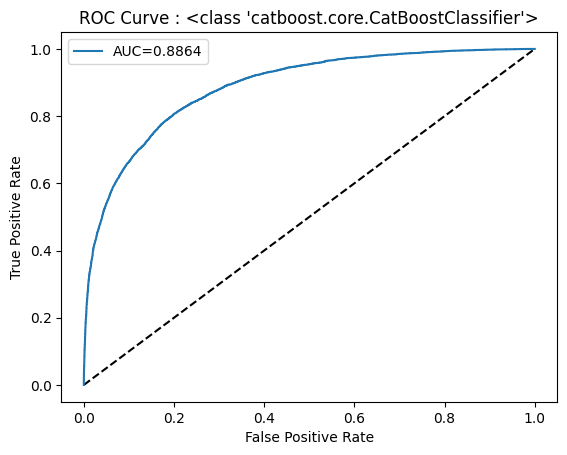

In [101]:
params = {
    'iterations': 8000,
    'learning_rate': 0.005,
    'loss_function': 'MultiClass',
    'l2_leaf_reg': 1,
    'max_ctr_complexity': 15,
    'max_depth': 10,
    'grow_policy': 'Lossguide',
    'max_leaves': 64,
    'min_data_in_leaf': 40,
    'random_seed': 42
}

model = CatBoostClassifier(**params, class_weights=class_weights)
model.fit(X_train, y_train, cat_features=categorical_features, verbose=1000)
clear_output()

def plot_roc_curve(model):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[::,1]
    accuracy = accuracy_score(y_test, y_pred).round(4)
    auc = roc_auc_score(y_test, y_pred_proba).round(4)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

    plt.plot([0, 1], [0, 1], linestyle='--', color='k')
    plt.plot(fpr, tpr, label='AUC=%0.4f'%(auc))
    plt.title('ROC Curve : %s'%(type(model)))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=0)
    plt.show()

plot_roc_curve(model)

## Model Inference

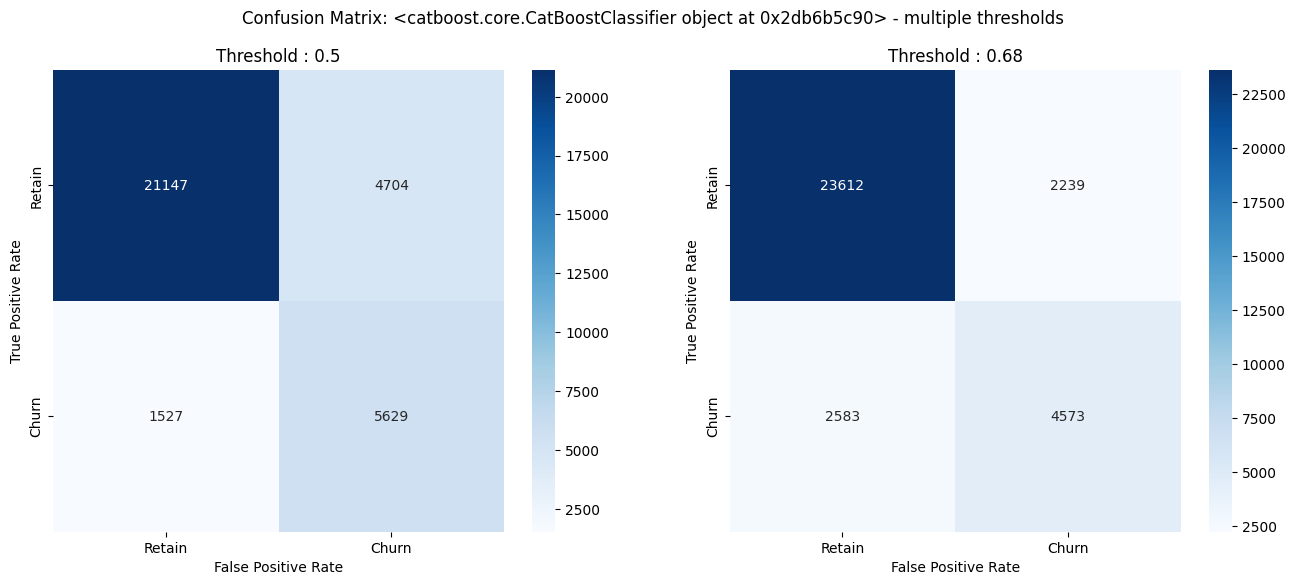

In [105]:
y_pred = model.predict(X_test)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

fig.suptitle('Confusion Matrix: %s - multiple thresholds'%(model))
labels = ['Retain', 'Churn']
thresholds = [0.5, 0.68]

for threshold, ax in zip(thresholds, axes):
    y_pred_threshold = (model.predict_proba(X_test)[:, 1] >= threshold).astype(int)
    matrix = confusion_matrix(y_test, y_pred_threshold)
    sns.heatmap(matrix, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_title('Threshold : %s'%threshold)
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')

In [110]:
test = df[df['split'] == 'test'].drop('split', axis=1)

test['Exited'] = model.predict_proba(test.drop(['Exited', 'id'], axis=1))[:, 1]
test[['id', 'Exited']].to_csv('submission.csv', index= False)

!head -5 submission.csv

id,Exited
165034,0.05651521701766068
165035,0.9405974429671771
165036,0.1357831081199213
165037,0.5581145972818331
